# Outliers Classification

## Description of the task

The objective of this work is to identify outliers within a dataset consisting of images of celebrities. Outliers in this context refer to images that deviate significantly from the overall patterns or characteristics present in the dataset. The task involves employing various methods, both supervised and unsupervised, to detect and classify these outliers.

Note: Training phases have been commented out in this notebook to prevent excessive execution time. Uncomment and execute specific sections as needed for a detailed exploration of training processes.

## Exploration of the dataset

Before devising a strategy to address the issue, let's take a closer look at the dataset. It comprises not only images but also associated labels, representing attributes for each image. We'll delve into both aspects to gain a better understanding.

In [1]:
#principals imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
!wget https://cloud.minesparis.psl.eu/index.php/s/0DMrlAG6CbsgY2o/download -O CelebA.zip
!unzip CelebA.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: CelebA/CelebA/Img/img_align_celeba/198821.jpg  
  inflating: CelebA/CelebA/Img/img_align_celeba/176330.jpg  
  inflating: CelebA/CelebA/Img/img_align_celeba/006881.jpg  
  inflating: CelebA/CelebA/Img/img_align_celeba/015013.jpg  
  inflating: CelebA/CelebA/Img/img_align_celeba/024792.jpg  
  inflating: CelebA/CelebA/Img/img_align_celeba/148191.jpg  
  inflating: CelebA/CelebA/Img/img_align_celeba/108869.jpg  
  inflating: CelebA/CelebA/Img/img_align_celeba/130998.jpg  
  inflating: CelebA/CelebA/Img/img_align_celeba/039459.jpg  
  inflating: CelebA/CelebA/Img/img_align_celeba/024818.jpg  
  inflating: CelebA/CelebA/Img/img_align_celeba/074708.jpg  
  inflating: CelebA/CelebA/Img/img_align_celeba/197701.jpg  
  inflating: CelebA/CelebA/Img/img_align_celeba/132212.jpg  
  inflating: CelebA/CelebA/Img/img_align_celeba/056198.jpg  
  inflating: CelebA/CelebA/Img/img_align_celeba/086438.jpg  
  infla

In [2]:
data_dir = "./CelebA/CelebA/Img/img_align_celeba/" # path to the image dataset

In [3]:
df_train = pd.read_csv("CelebA/CelebA/train_celeba.csv").rename({"Unnamed: 0": "name"}, axis = 1).set_index("name") # train dataset
df_val = pd.read_csv("CelebA/CelebA/val_celeba.csv").rename({"Unnamed: 0": "name"}, axis = 1).set_index("name") # validation dataset
df_test = pd.read_csv("CelebA/CelebA/test_celeba.csv").rename({"Unnamed: 0": "name"}, axis = 1).set_index("name") # test dataset

In [4]:
df_train.head()

5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
name                                                                         
093242.jpg                -1               -1          -1               -1   
121414.jpg                -1               -1           1               -1   
010625.jpg                 1               -1          -1                1   
082524.jpg                -1                1           1                1   
073193.jpg                -1               -1          -1               -1   

            Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  Blond_Hair  ...  \
name                                                                 ...   
093242.jpg    -1     -1        -1        -1           1          -1  ...   
121414.jpg    -1     -1        -1        -1          -1          -1  ...   
010625.jpg    -1     -1        -1         1          -1          -1  ...   
082524.jpg    -1     -1         1        -1          -1          -1  ...   
073193.jpg    -1     -1        -1        -1          -1           1  ...   

            Sideburns  Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  \
name                                                                         
093242.jpg          1       -1             -1          1                -1   
121414.jpg         -1       -1             -1         -1                -1   
010625.jpg         -1       -1             -1          1                -1   
082524.jpg         -1        1             -1         -1                -1   
073193.jpg         -1        1              1         -1                 1   

            Wearing_Hat  Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  \
name                                                                           
093242.jpg           -1                -1                -1               -1   
121414.jpg           -1                 1                -1               -1   
010625.jpg           -1                -1                -1               -1   
082524.jpg           -1                 1                -1               -1   
073193.jpg           -1                -1                -1               -1   

            Young  
name               
093242.jpg      1  
121414.jpg      1  
010625.jpg      1  
082524.jpg      1  
073193.jpg     -1  

[5 rows x 40 columns]

In [5]:
df_train.columns, len(df_train.columns)

(Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
        'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
        'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
        'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
        'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
        'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
        'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
        'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
        'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
       dtype='object'),
 40)

We have visibility into all 40 features, each capable of assuming a value of -1 or 1, indicating its presence or absence in the image. Recognizing that these features play a crucial role in identifying outliers, we can infer that an image deviating by lacking a feature present in all other images may be reasonably categorized as an outlier. Let's now shift our attention to the images.

In [6]:
len(df_train), len(df_val)

(121559, 40520)

With 121,559 images in the training set and 40,520 in the validation set, we have a substantial amount of data, assuming reasonable image quality. To conduct a more in-depth analysis, we'll proceed by creating PyTorch Dataset objects.

In [8]:
from torch.utils.data import Dataset # library to create custom datasets
import torchvision # library to load the dataset
from PIL import Image # PIL is a library to manipulate images
import random

class CelebDataset(Dataset):

    def pil_loader(self, path: str) -> Image.Image:
        with open(path, "rb") as f:
            img = Image.open(f)
            return img.convert("RGB")

    def __init__(self,data_df, data_dir, transforms=None):
        self.transforms = transforms # transformation to apply to the images
        self.data_df = data_df # dataframe with the images names and the labels
        self.data_dir = data_dir # path to the images

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self,idx):

        img_filename = self.data_df.index[idx]
        label = self.data_df.iloc[idx].values
        label[label == -1] = 0 # map to range from 0 to 1

        image = self.pil_loader(os.path.join(self.data_dir,str(img_filename)))

        if self.transforms is not None:
            image_tensor = self.transforms(image)
        else:
            image_tensor = torchvision.transforms.functional.to_tensor(image)

        label = torch.tensor(label).float() # convert to pytorch tensor

        return image_tensor, label

    def sample(self, N):
        """
        Plot N random images from the dataset in a square grid.
        """
        if N > len(self):
            raise ValueError("N cannot be greater than the total number of images in the dataset.")

        # Calculate the number of rows and columns for the subplot
        num_cols = int(np.sqrt(N))
        num_rows = int(np.ceil(N / num_cols))

        # Randomly sample N indices
        random_indices = random.sample(range(len(self)), N)

        # Create a subplot with a square grid
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(8, 8))

        for i, idx in enumerate(random_indices):
            row = i // num_cols
            col = i % num_cols

            img_filename = self.data_df.index[idx]
            image = self.pil_loader(os.path.join(self.data_dir, str(img_filename)))

            if self.transforms is not None:
                image_tensor = self.transforms(image)
            else:
                image_tensor = torchvision.transforms.functional.to_tensor(image)

            # Plot the image
            axs[row, col].imshow(image_tensor.permute(1, 2, 0))  # permute to (H, W, C)
            axs[row, col].axis('off')

        # Remove empty subplots if N is not a perfect square
        for i in range(N, num_cols * num_rows):
            fig.delaxes(axs.flatten()[i])

        plt.tight_layout()
        plt.show()

Now that we've crafted our custom class for dataset management, let's put it to use.

In [9]:
train_data = CelebDataset(df_train, data_dir)
val_data = CelebDataset(df_val, data_dir)
test_data = CelebDataset(df_test, data_dir)

We can begin by analysing size of images.

In [10]:
shapes = []
for data in train_data:
    shapes.append(data[0].shape)

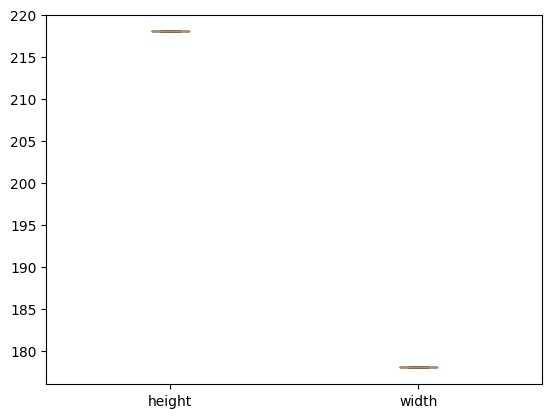

In [11]:
shapes = np.array(shapes)
plt.boxplot(shapes[:,1:], labels = ["height", "width"]);

In [12]:
(shapes[:,1] == 218).sum() == len(shapes), (shapes[:,2] == 178).sum() == len(shapes)

(True, True)

Observing that all images share the same dimensions (218, 178, 3), we can now visualize a selection of random images to gain a representative overview of the dataset.

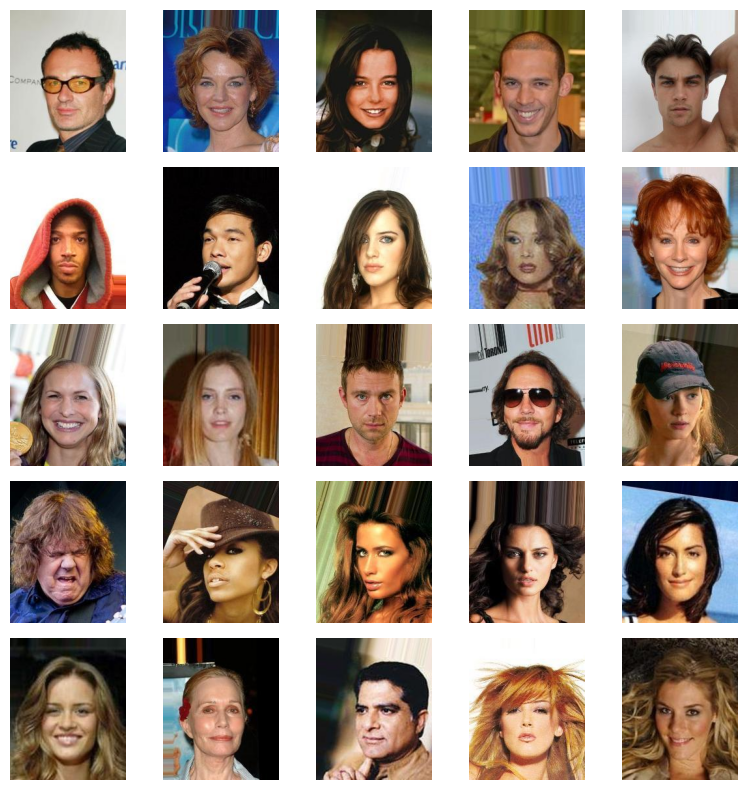

In [13]:
train_data.sample(25)

By examining batches of images, we can glean insights into potential outliers based on various factors:
- Some images may lack optimal resolution.
- Blurriness could be indicative of certain images.
- Differences in the celebrities' attitudes, such as smiling or not, might signal outliers.
- Varied photo styles, like candid shots versus well-framed portraits, could distinguish outliers.

Considering these observations, we plan to explore two distinct approaches:
1. A supervised approach leveraging the diverse features at our disposal.
2. An unsupervised approach focusing on image quality and composition, less reliant on explicit features.

## Supervised method

In this method, our approach involves utilizing the available labels. The primary objective is to first identify which labels hold discriminatory power in identifying outliers within the dataset. Subsequently, we aim to implement a label prediction method and explore the potential of determining outliers based on the label values associated with each image.

Our initial step involves a closer examination of the attributes at our disposal, focusing on identifying which ones are pertinent for outlier detection. Specifically, we seek to identify attributes that are underrepresented in the database, as they may serve as key indicators for outlier identification.

In [14]:
df_train.columns

Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')

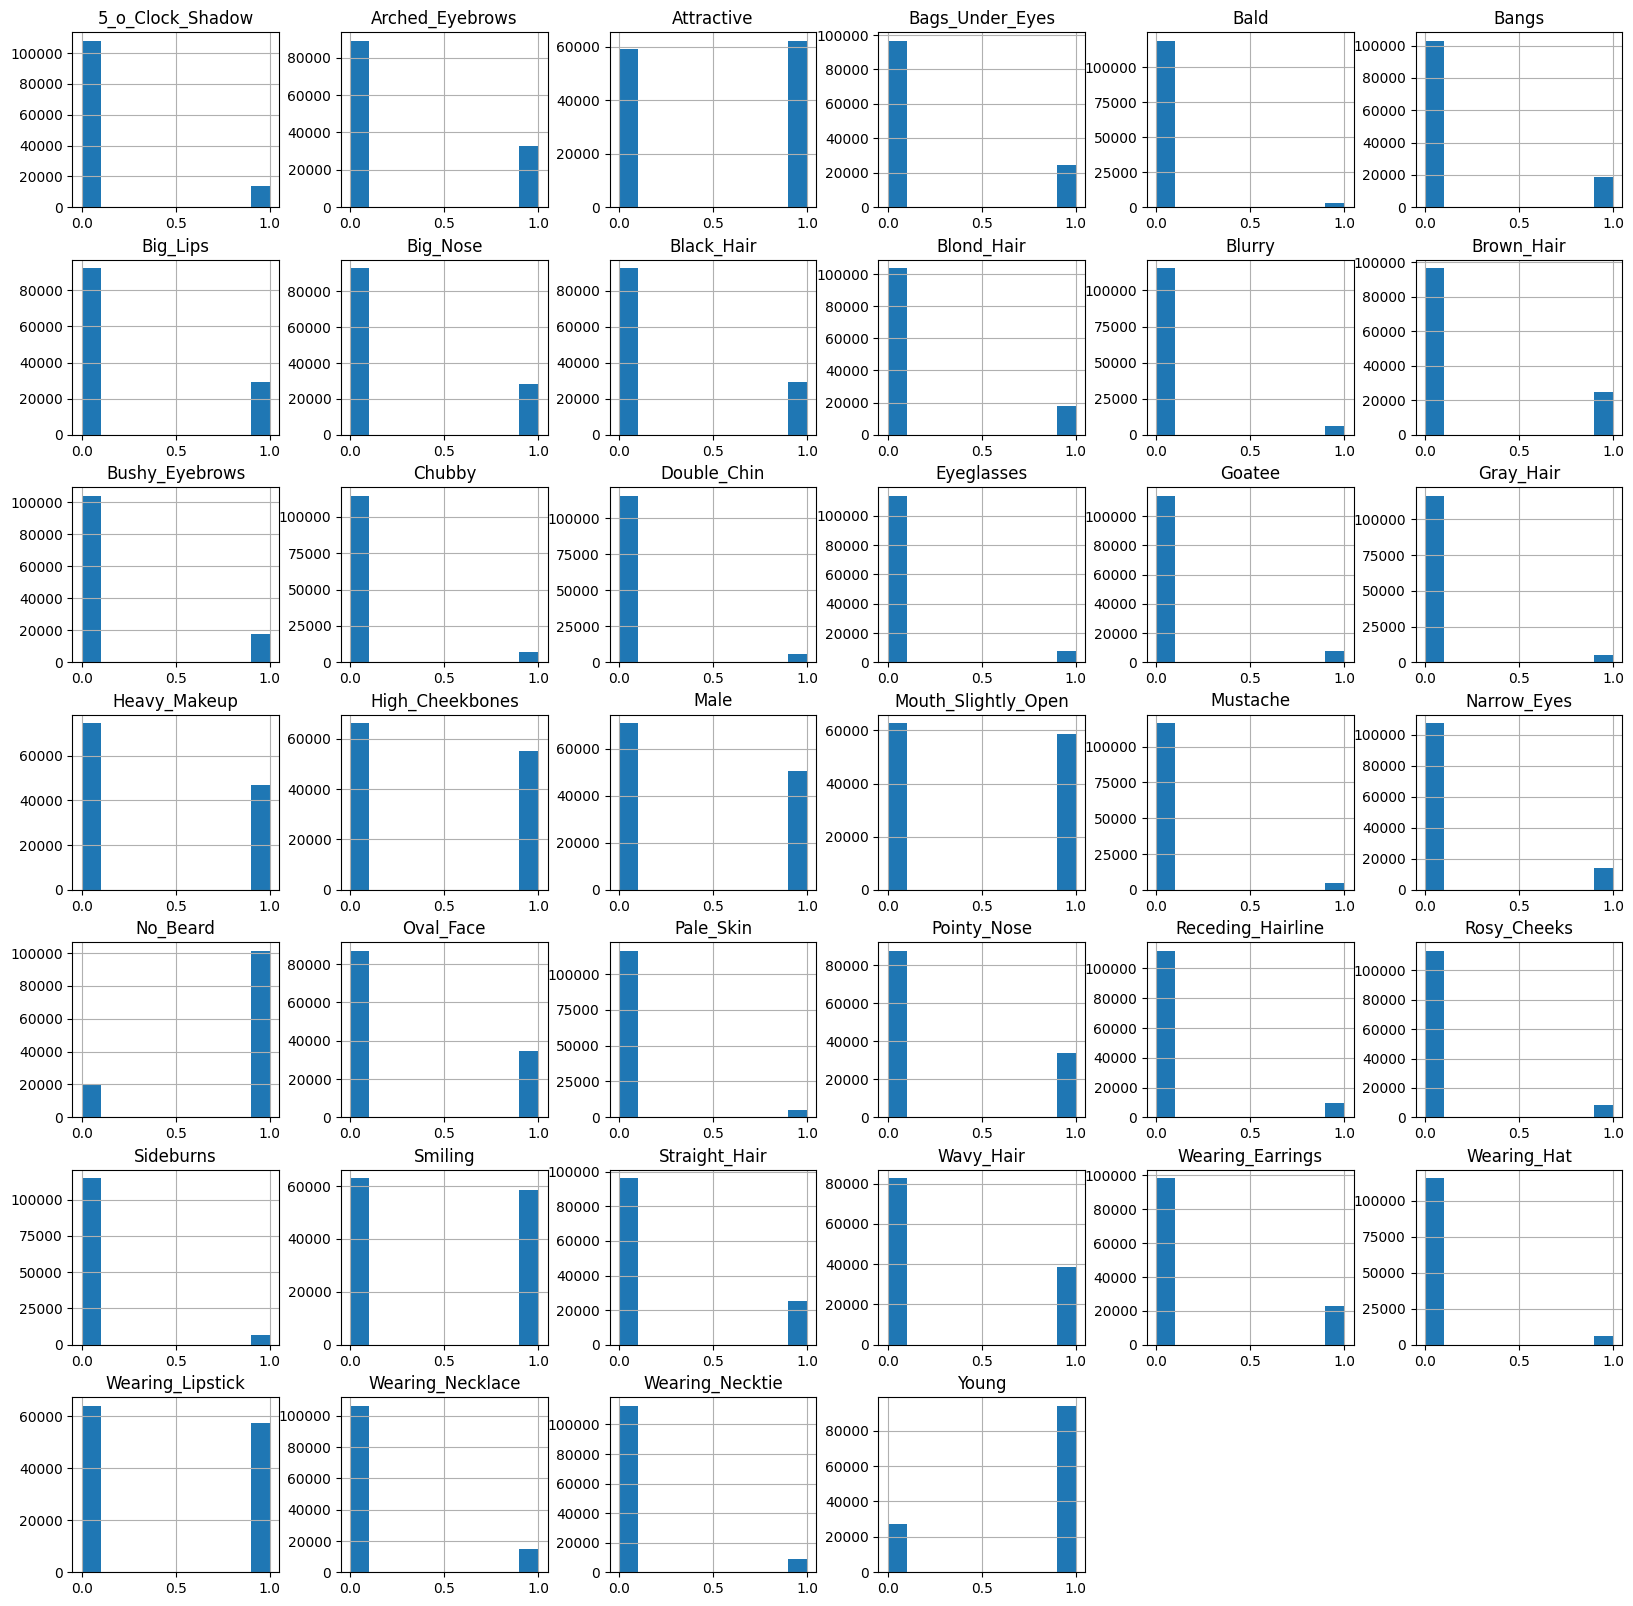

In [15]:
df_train.hist(figsize = (20,20));

Observing the distribution of features, we note that certain attributes exhibit a balanced proportion (e.g., attractive, smiling), while others demonstrate a significant imbalance (e.g., wearing a hat, gray hair). To enhance our outlier detection strategy, we intend to focus on criteria characterized by a pronounced imbalance, as these attributes may offer more discriminatory power in identifying outliers.

In [16]:
outliers_based_feature = []
ceil = 0.1
N = len(df_train)

df_train[df_train == -1] = 0

for column in df_train.columns:
    if (df_train[column].sum() < ceil * N) or (df_train[column].sum() > (1 - ceil) * N):
        outliers_based_feature.append(column)

In [17]:
outliers_based_feature

['Bald',
 'Blurry',
 'Chubby',
 'Double_Chin',
 'Eyeglasses',
 'Goatee',
 'Gray_Hair',
 'Mustache',
 'Pale_Skin',
 'Receding_Hairline',
 'Rosy_Cheeks',
 'Sideburns',
 'Wearing_Hat',
 'Wearing_Necktie']

After filtering features that either represent less than 10% or more than 90% of the dataset, we have identified 14 features for outlier detection. To establish a criterion for outlier determination, we propose considering an image as an outlier if it falls in the minority for at least N of these selected features. The value of N will serve as a hyperparameter, allowing for adjustment based on the desired percentage of outliers.

4833


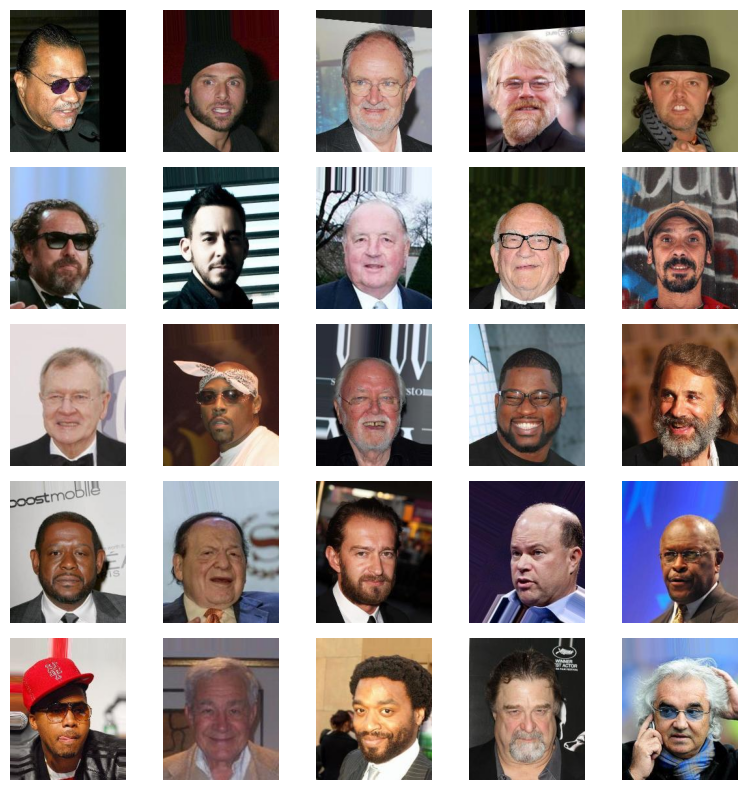

In [ ]:
N = 4
df_outlier = df_train[df_train[outliers_based_feature].sum(axis = 1) >= N]
outliers_train = CelebDataset(df_outlier, data_dir)
print(len(outliers_train))
outliers_train.sample(25)

Setting N = 4, we identify 4,833 images as outliers, constituting roughly 4% of the training dataframe. Upon visual inspection, some images are clearly distinguishable as outliers by human judgment—featuring fantasy elements, elaborate hats, or exhibiting blurriness. However, certain images categorized as outliers may appear entirely 'normal' to the human eye. The seeming contradiction arises from our defined outlier criteria, which includes images deviating from the majority based on selected features.

To mitigate the inclusion of these 'normal' images in the outlier category, a model adjustment is necessary. However, achieving this in a supervised learning context poses challenges given the nature of available features. Distinguishing between a 'fantasy' hat and a common one, or discerning between fantasy and prescription glasses, proves intricate and may not be suitable for outlier detection.

Despite this challenge, outlier detection aims to highlight images that deviate from the dataset norm, encompassing these images as per our defined criteria.

In conclusion, we intend to finalize this method. To achieve this, we require a model capable of extracting the selected features from each image. While a binary classifier to directly determine outlier status is an option, the former approach appears more general and reusable.

__Define the Dataset__

In [18]:
# prepare the data loaders
batch_size = 128
num_workers = 4

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor(), # This step already scales pixel values of 255 -> 0-1
])

train_data = CelebDataset(df_train[outliers_based_feature], data_dir, transforms=transforms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=num_workers)

val_data = CelebDataset(df_val[outliers_based_feature], data_dir, transforms=transforms)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers)

test_data = CelebDataset(df_test[outliers_based_feature], data_dir, transforms=transforms)
test_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/util

__Import the model__

In [19]:
from torchvision.models import resnet18, ResNet18_Weights

classifier = resnet18(weights=ResNet18_Weights.DEFAULT)
classifier.fc = nn.Linear(512, len(outliers_based_feature)) # add a fully connected layer with the number of classes as output
classifier = torch.nn.DataParallel(classifier).cuda()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


__Setting up the model__

In [20]:
class_criterion = nn.BCELoss() # binary cross entropy loss
class_optimizer = optim.Adam(classifier.parameters(), lr=0.001) # adam optimizer

__Define useful function for train__

In [21]:
def train_classifier(classifier,epochs=10):
    """Train a classifier.

    Args:
        classifier: classifier to train
        epochs (int, optional): number of epochs. Defaults to 10.
    """
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        classifier.train()

        for i, data in enumerate(train_loader):

            inputs, labels = data

            inputs = inputs.cuda()
            labels = labels.cuda()

            # zero the parameter gradients
            class_optimizer.zero_grad()

            # forward + backward + optimize
            outputs = torch.nn.functional.sigmoid(classifier(inputs)) # If you use BCELoss you need to transform the output to the range [0,1] if the network (like a resnet) does not do that on it's own. CrossEntropyLoss adds it's own softmax in pytorch

            loss = class_criterion(outputs, labels)

            loss.backward()

            class_optimizer.step()

            with torch.no_grad():
                # print statistics
                running_loss += loss.item()
                if i % 10 == 9:    # print every xxx mini-batches
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                    running_loss = 0.0


    print('Finished Training')

__Define useful function for validation__

In [22]:
def val_classifier(classifier, data_loader):

    output_values = []
    target_values = []

    running_loss = 0.0
    classifier.eval()

    with torch.no_grad():
        for i, data in enumerate(data_loader):

            inputs, labels = data

            inputs = inputs.cuda()
            labels = labels.cuda()

            # forward + backward + optimize
            outputs =  torch.nn.functional.sigmoid(classifier(inputs))

            loss = class_criterion(outputs, labels)

            output_values.extend(outputs.cpu().numpy())
            target_values.extend(labels.flatten(1).cpu().numpy())

            # print statistics
            running_loss += loss.item()

    print(f'loss: {running_loss / 2000:.3f}')
    return output_values, target_values

In [23]:
torch.cuda.empty_cache() # empty the cache to avoid memory errors

__Training the classifier__

In [24]:
#train_classifier(classifier,epochs=1)

In [26]:
classifier.load_state_dict(torch.load("weight_classif.pth"))

<All keys matched successfully>

In [27]:
torch.cuda.empty_cache() # empty the cache to avoid memory errors

__Validation__

In [28]:
output_values, target_values = val_classifier(classifier, val_loader)
output_values = np.array(output_values)
target_values = np.array(target_values)

loss: 0.014


In [29]:
torch.cuda.empty_cache() # empty the cache to avoid memory errors

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

accuracies = [accuracy_score(target_values[:, i], (output_values[:, i] > 0.5).astype(int)) for i in range(len(outliers_based_feature))]
precisions = [precision_score(target_values[:, i], (output_values[:, i] > 0.5).astype(int)) for i in range(len(outliers_based_feature))]
recalls = [recall_score(target_values[:, i], (output_values[:, i] > 0.5).astype(int)) for i in range(len(outliers_based_feature))]
f1_scores = [f1_score(target_values[:, i], (output_values[:, i] > 0.5).astype(int)) for i in range(len(outliers_based_feature))]

for i, acc in enumerate(accuracies):
    print(f'Accuracy for feature {i + 1}: {acc}')
print("-----------------------------")
for i, prec in enumerate(precisions):
    print(f'Precision for feature {i + 1}: {prec}')
print("-----------------------------")
for i, rec in enumerate(recalls):
    print(f'Recall for feature {i + 1}: {rec}')
print("-----------------------------")
for i, f1 in enumerate(f1_scores):
    print(f'F1 score for feature {i + 1} : {f1}')

Accuracy for feature 1: 0.9863030602171767
Accuracy for feature 2: 0.9559723593287266
Accuracy for feature 3: 0.9357847976307996
Accuracy for feature 4: 0.9505676209279368
Accuracy for feature 5: 0.9955330700888451
Accuracy for feature 6: 0.9662882527147088
Accuracy for feature 7: 0.9757403751233958
Accuracy for feature 8: 0.965893385982231
Accuracy for feature 9: 0.9584402764067127
Accuracy for feature 10: 0.9211747285291214
Accuracy for feature 11: 0.9488400789733465
Accuracy for feature 12: 0.9686080947680158
Accuracy for feature 13: 0.9850197433366239
Accuracy for feature 14: 0.9653257650542941
-----------------------------
Precision for feature 1: 0.6577355229040622
Precision for feature 2: 0.5655806182121972
Precision for feature 3: 0.47592385218365063
Precision for feature 4: 0.48240841494377945
Precision for feature 5: 0.9836997725549659
Precision for feature 6: 0.7058823529411765
Precision for feature 7: 0.76
Precision for feature 8: 0.6203037569944044
Precision for feature 9:

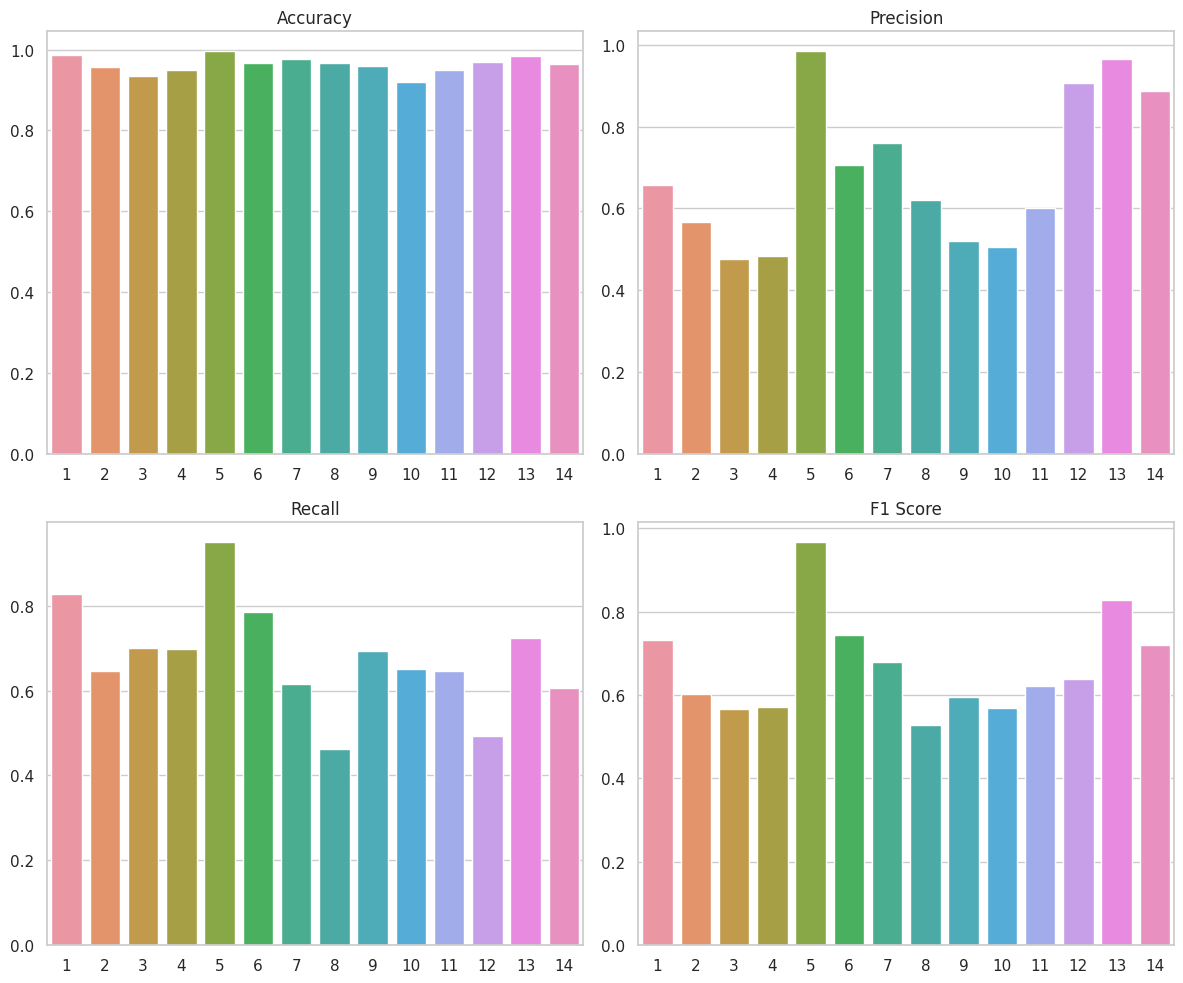

In [31]:
sns.set(style="whitegrid")

# features
features = np.arange(1, len(outliers_based_feature) + 1)

# create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Accuracy
sns.barplot(x=features, y=accuracies, ax=axes[0, 0])
axes[0, 0].set_title('Accuracy')

# Precision
sns.barplot(x=features, y=precisions, ax=axes[0, 1])
axes[0, 1].set_title('Precision')

# Recall
sns.barplot(x=features, y=recalls, ax=axes[1, 0])
axes[1, 0].set_title('Recall')

# F1 Score
sns.barplot(x=features, y=f1_scores, ax=axes[1, 1])
axes[1, 1].set_title('F1 Score')

plt.tight_layout()
plt.show()

This method demonstrates promising results on the validation data. The validation process played a crucial role in refining hyperparameters, particularly the learning rate and the L2 regularization coefficient, aimed at preventing overfitting. As we observed a slight overfitting during training, we fine-tuned the regularization coefficient to address this issue. Additionally, in an effort to further alleviate overfitting, we experimented with modifying the standard ResNet architecture by incorporating dropout layers. However, this adjustment did not yield satisfactory results on the validation set, prompting us to set it aside. It's worth noting that due to the extensive training time, exploring a wide range of models and hyperparameters poses a considerable challenge.

__Test__

In [32]:
output_values, target_values = val_classifier(classifier, test_loader)
output_values = np.array(output_values)
target_values = np.array(target_values)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


loss: 0.014


In [33]:
accuracies = [accuracy_score(target_values[:, i], (output_values[:, i] > 0.5).astype(int)) for i in range(len(outliers_based_feature))]
confusion_matrices = [confusion_matrix(target_values[:, i], (output_values[:, i] > 0.5).astype(int)) for i in range(len(outliers_based_feature))]
precisions = [precision_score(target_values[:, i], (output_values[:, i] > 0.5).astype(int)) for i in range(len(outliers_based_feature))]
recalls = [recall_score(target_values[:, i], (output_values[:, i] > 0.5).astype(int)) for i in range(len(outliers_based_feature))]
f1_scores = [f1_score(target_values[:, i], (output_values[:, i] > 0.5).astype(int)) for i in range(len(outliers_based_feature))]

for i, acc in enumerate(accuracies):
    print(f'Accuracy for feature {i + 1}: {acc}')
print("-----------------------------")
for i, prec in enumerate(precisions):
    print(f'Precision for feature {i + 1}: {prec}')
print("-----------------------------")
for i, rec in enumerate(recalls):
    print(f'Recall for feature {i + 1}: {rec}')
print("-----------------------------")
for i, f1 in enumerate(f1_scores):
    print(f'F1 score for feature {i + 1} : {f1}')

Accuracy for feature 1: 0.9863030602171767
Accuracy for feature 2: 0.9559723593287266
Accuracy for feature 3: 0.9357847976307996
Accuracy for feature 4: 0.9505676209279368
Accuracy for feature 5: 0.9955330700888451
Accuracy for feature 6: 0.9662882527147088
Accuracy for feature 7: 0.9757403751233958
Accuracy for feature 8: 0.965893385982231
Accuracy for feature 9: 0.9584402764067127
Accuracy for feature 10: 0.9211747285291214
Accuracy for feature 11: 0.9488400789733465
Accuracy for feature 12: 0.9686080947680158
Accuracy for feature 13: 0.9850197433366239
Accuracy for feature 14: 0.9653257650542941
-----------------------------
Precision for feature 1: 0.6577355229040622
Precision for feature 2: 0.5655806182121972
Precision for feature 3: 0.47592385218365063
Precision for feature 4: 0.48240841494377945
Precision for feature 5: 0.9836997725549659
Precision for feature 6: 0.7058823529411765
Precision for feature 7: 0.76
Precision for feature 8: 0.6203037569944044
Precision for feature 9:

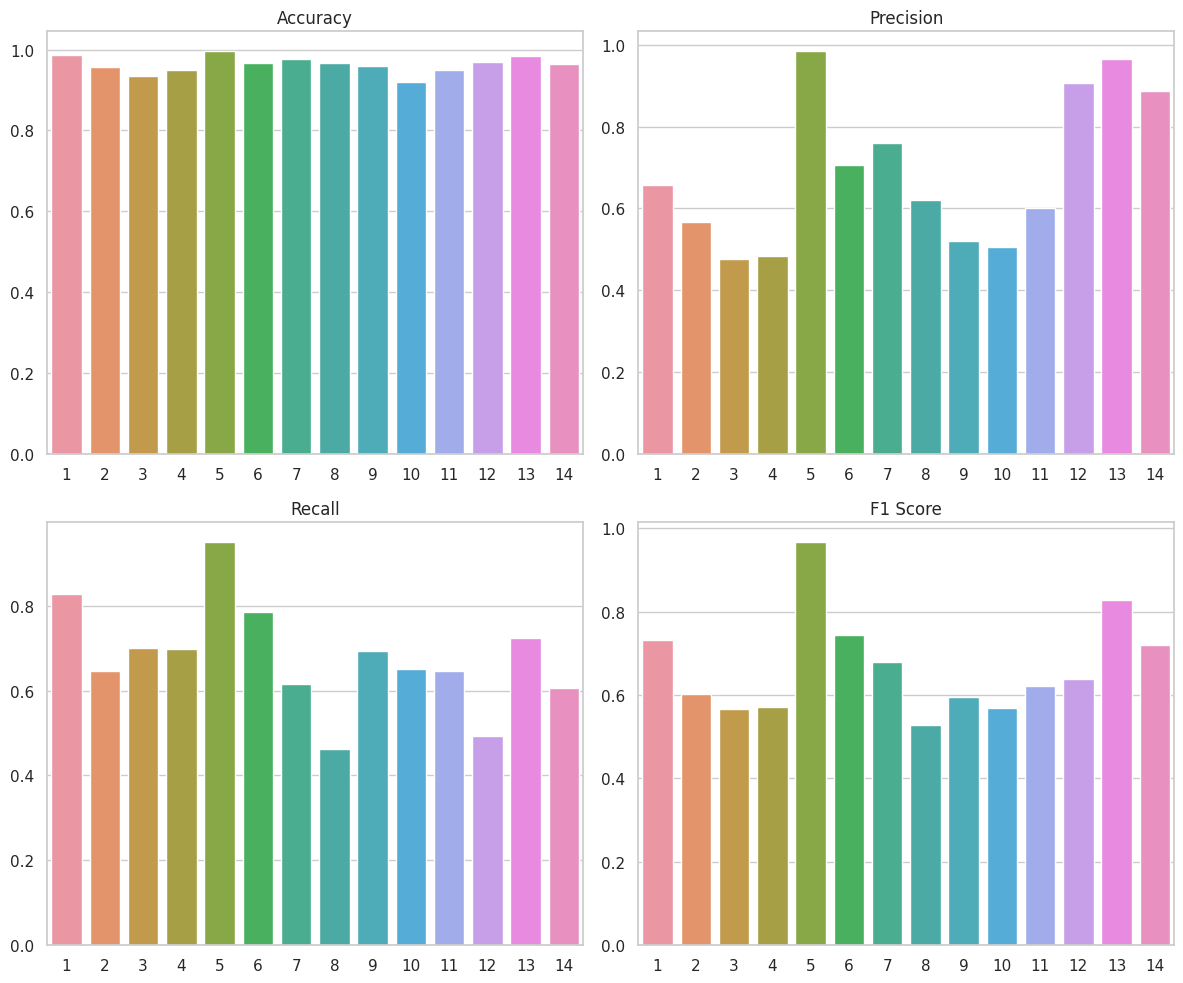

In [34]:
sns.set(style="whitegrid")

#features
features = np.arange(1, len(outliers_based_feature) + 1)

# Créer des sous-plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Accuracy
sns.barplot(x=features, y=accuracies, ax=axes[0, 0])
axes[0, 0].set_title('Accuracy')

# Precision
sns.barplot(x=features, y=precisions, ax=axes[0, 1])
axes[0, 1].set_title('Precision')

# Recall
sns.barplot(x=features, y=recalls, ax=axes[1, 0])
axes[1, 0].set_title('Recall')

# F1 Score
sns.barplot(x=features, y=f1_scores, ax=axes[1, 1])
axes[1, 1].set_title('F1 Score')

plt.tight_layout()
plt.show()

## Unsupervised method

The initial supervised method effectively detects outliers by targeting features deemed rare in images. However, we seek an alternative approach to identify outliers, specifically targeting images of lower quality or less seriousness. For this purpose, we employ an unsupervised method using an Autoencoder—a neural network designed to reconstruct images from themselves through a lower-dimensional latent space. Our approach is influenced by the principles outlined in the following articles: [1](http://saketsathe.net/downloads/autoencode.pdf) and [2](https://www.sciencedirect.com/science/article/abs/pii/S0957417422019224).

In our Autoencoder-based outlier detection, the objective is to have outliers reconstructed less effectively than normal images. The second paper suggests pre-clustering images to exclude outliers from the autoencoder training. Although initial attempts with a basic classification algorithm (K-means) did not yield significant results, we explored alternative approaches. Instead of directly applying the K-means algorithm, we opted for dimensionality reduction, experimenting with two methods: PCA and features from the latent space of an initial Autoencoder.

As these clustering methods did not produce satisfactory outcomes, we pursued a different strategy. Given our emphasis on outlier detection related to image quality, we experimented with excluding low-quality images from autoencoder training. To perform this analysis, we employed the Laplace filter, as recommended in this article: [3](https://medium.com/@sahilutekar.su/detecting-blur-and-bright-spots-in-images-using-python-and-opencv-6bab8ce75404).

__Search blur images__

In [35]:
"""
laplacians = []
image_names = df_train.index

for i, image_name in enumerate(image_names):
  laplacians.append(cv2.Laplacian(cv2.cvtColor(cv2.imread(os.path.join(data_dir, image_name)), cv2.COLOR_BGR2GRAY), cv2.CV_64F).var())
  if (i % 10000 == 0):
    print(i)
df_lap_train = pd.DataFrame(laplacians, index=df_train.index, columns = ["Laplacian"])
df_lap_train["noBlur"] = (df_lap_train >= df_lap_train.quantile(0.10))
"""

'\nlaplacians = []\nimage_names = df_train.index\n\nfor i, image_name in enumerate(image_names):\n  laplacians.append(cv2.Laplacian(cv2.cvtColor(cv2.imread(os.path.join(data_dir, image_name)), cv2.COLOR_BGR2GRAY), cv2.CV_64F).var())\n  if (i % 10000 == 0):\n    print(i)\ndf_lap_train = pd.DataFrame(laplacians, index=df_train.index, columns = ["Laplacian"])\ndf_lap_train["noBlur"] = (df_lap_train >= df_lap_train.quantile(0.10))\n'

In [36]:
df_lap_train = pd.read_csv("blur_train.csv").set_index("name")
df_lap_train["noBlur"] = (df_lap_train >= df_lap_train.quantile(0.20))

In [37]:
df_no_blur = df_lap_train[df_lap_train["noBlur"]]
not_blur_images = CelebDataset(df_no_blur, data_dir)

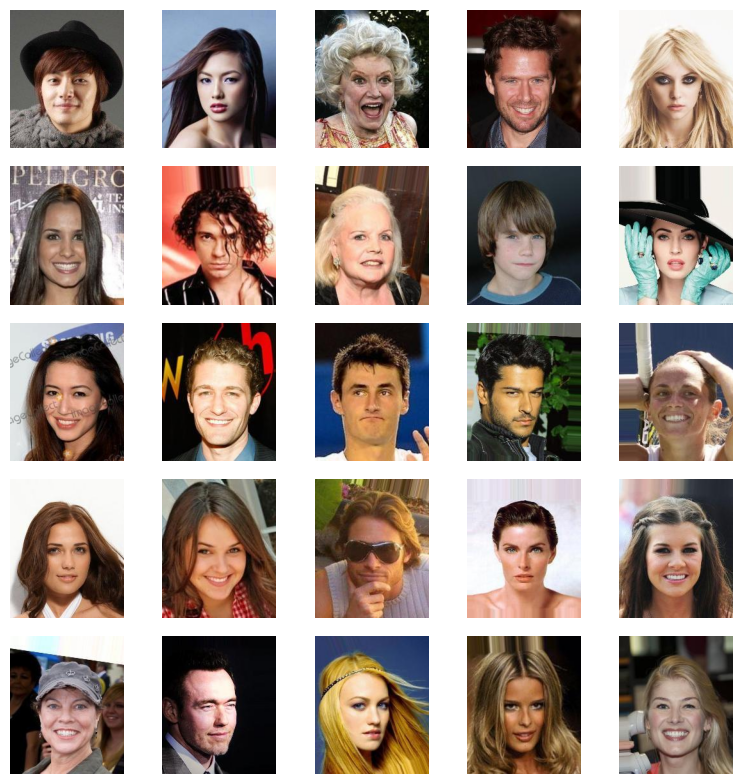

In [38]:
not_blur_images.sample(25) # show good quality images

Having retained only images in the top 80% of quality, we still observe the presence of some images with motion blur trails that we aim to eliminate. Despite experimenting with various methods such as Fourier transform and contour detection, none have provided definitive results.

With a subset of high-quality images, our next step involves constructing the autoencoder and training it on these predominantly non-outlying samples. Let's begin by defining our data loader and outlining the architecture of the autoencoder.



__Load Data__

In [39]:
# prepare the data loaders
batch_size = 128
num_workers = 4

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor(), # This step already scales pixel values of 255 -> 0-1
])

train_data = CelebDataset(df_train[df_lap_train["noBlur"] == 1], data_dir, transforms=transforms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=num_workers)

val_data = CelebDataset(df_val, data_dir, transforms=transforms)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=1, shuffle=False, drop_last=False, num_workers=num_workers)

test_data = CelebDataset(df_test, data_dir, transforms=transforms)
test_loader = torch.utils.data.DataLoader(val_data, batch_size=1, shuffle=False, drop_last=False, num_workers=num_workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


__Define Autoencoder__

In [40]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=256):
        super(Autoencoder, self).__init__()

        # Encodeur
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(512, latent_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
        )

        # Décoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        latent_space = x
        x = self.decoder(x)
        return x, latent_space


In [41]:
model = Autoencoder(latent_dim = 500)
model = torch.nn.DataParallel(model).cuda()

In [42]:
learning_rate = 1e-3

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

__Training__

In [43]:
def train_autoencoder(autoencoder, criterion, optimizer, epochs=10):
    """Train a classifier.

    Args:
        autoencoder: autoencoder to train
        criterion: loss to use
        optimizer: optimizer to use
        epochs (int, optional): number of epochs. Defaults to 10.
    """
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        autoencoder.train()

        for i, data in enumerate(train_loader):

            inputs, _ = data # we don't use labels
            inputs = inputs.cuda()

            optimizer.zero_grad()

            outputs, _ = autoencoder(inputs)

            loss = criterion(inputs, outputs)

            loss.backward()

            optimizer.step()

            with torch.no_grad():
                # print statistics
                running_loss += loss.item()
                if i % 10 == 9:    # print every 10 mini-batches
                    print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / (i+1)}')
                    running_loss = 0.0


    print('Finished Training')

In [44]:
#torch.cuda.empty_cache() # empty the cache to avoid memory errors
#train_autoencoder(model, criterion, optimizer, epochs = 1)
#torch.save(model.state_dict(), "weights_autoencoder.pth")

In [45]:
model.load_state_dict(torch.load("/content/weights_autoencoder3_500.pth"))

<All keys matched successfully>

__Validation__

In [46]:
def val_autoencoder(model, criterion, data_loader):
    running_loss = 0.0
    losses = []
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(data_loader):
            inputs, _ = data
            inputs = inputs.cuda()

            loss = criterion(inputs, model(inputs)[0])

            # Print statistics
            running_loss += loss.item()
            if (i % 1000 == 0):
                print(i)

            losses.append(loss.item()) # save loss

    print(f'Loss: {running_loss / len(data_loader):.3f}')
    return losses


def visualize_random_sample(model, criterion, data_loader):
    model.eval()
    with torch.no_grad():
      # Sélectionnez un élément aléatoire de la DataLoader
      random_index = torch.randint(0, len(data_loader.dataset), (1,))
      random_sample, _ = data_loader.dataset[random_index.item()]

      # Ajoutez une dimension pour simuler une batch de taille 1
      input_image = random_sample.unsqueeze(0).cuda()

      # Passez l'image à travers le modèle pour l'obtenir reconstruite
      reconstructed_image, _ = model(input_image)

      # Convertissez les images en format numpy pour l'affichage avec Matplotlib
      input_image_np = input_image.cpu().squeeze().numpy()
      reconstructed_image_np = reconstructed_image.cpu().squeeze().numpy()

    print(f"MSE : {criterion(input_image, reconstructed_image).item()}")
    # Affichez l'image originale et l'image reconstruite
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(input_image_np.transpose((1, 2, 0)))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Reconstructed Image')
    plt.imshow(reconstructed_image_np.transpose((1, 2, 0)))
    plt.axis('off')

    plt.show()

MSE : 0.0025844047777354717


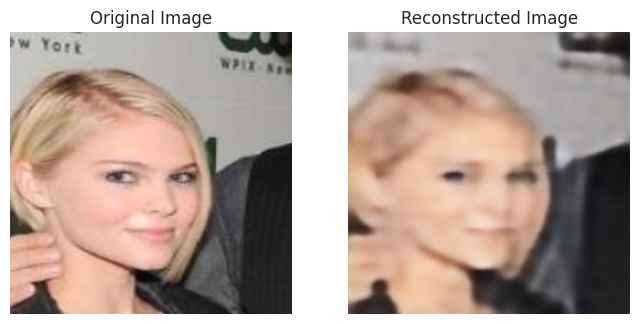

In [47]:
visualize_random_sample(model, criterion, val_loader)

Having successfully trained our autoencoder, we will explore two methods for outlier detection. The first method involves solely reconstructing the image and assessing the reconstruction error. By establishing a threshold, we can classify images as outliers if the reconstruction error surpasses this threshold. The second method entails representing each image by its latent space and employing clustering.

Upon analysis, we observe that the reconstruction quality is not optimal, leading to low reconstruction errors for blurry images—contrary to our outlier detection objective. Consequently, the efficacy of the first method is likely compromised. While we could enhance our autoencoder, computational limitations constrain our ability to develop a more intricate model.

### 1st Method

In [52]:
#torch.cuda.empty_cache()
#losses = val_autoencoder(model, criterion, val_loader)
#df_loss_val = pd.DataFrame(losses, columns = ["loss"]).set_index(df_val.index)
#df_loss_val.to_csv("loss_val.csv")

In [53]:
df_loss_val = pd.read_csv("loss_val.csv").set_index("name")
losses = df_loss_val["loss"].values

For the conclusive classification of outliers, we calculate the Mean Squared Error (MSE) between each value and its reconstruction through the autoencoder. By obtaining the MSE values for all images, we identify outliers using the Interquartile Range (IQR) method. Alternatively, we have the option to establish a threshold, designating images with a reconstruction error surpassing this threshold as outliers.

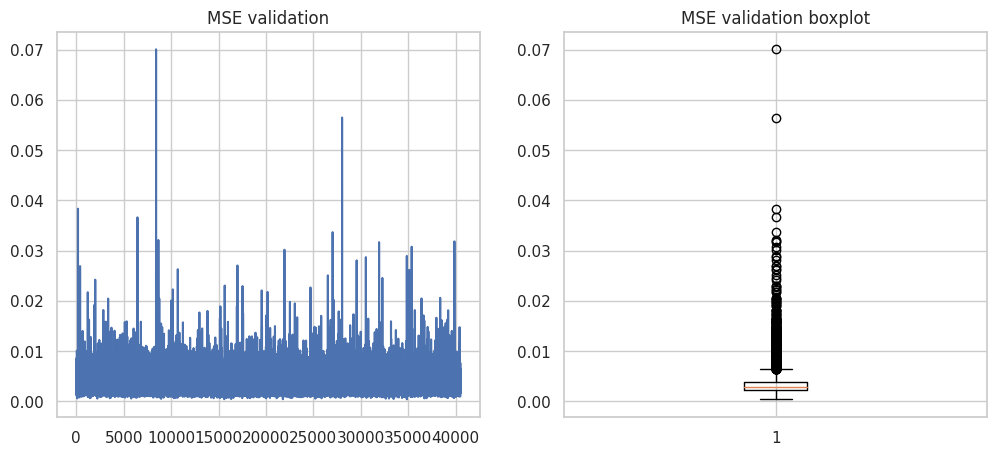

In [54]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.plot(losses)
plt.title("MSE validation")

plt.subplot(1,2,2)
plt.boxplot(losses)
plt.title("MSE validation boxplot");

In [55]:
def detect_outliers_iqr(losses):
    q1 = np.percentile(losses, 25)
    q3 = np.percentile(losses, 75)

    iqr = q3 - q1

    threshold = q3 + 1.5 * iqr

    outliers = [i for i, loss in enumerate(losses) if loss > threshold]

    return outliers

outliers = detect_outliers_iqr(losses)
df_outliers = df_loss_val.iloc[outliers, :]
len(df_outliers) / len(df_val)

0.04933366238894373

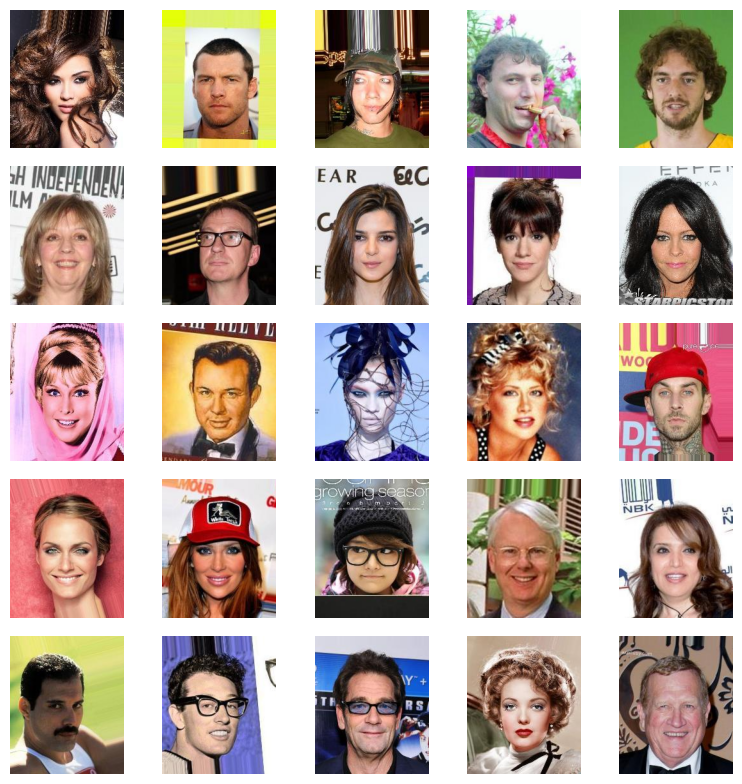

In [56]:
outliers_data_set = CelebDataset(df_outliers, data_dir)
outliers_data_set.sample(25)

__Conclusion of the First Method__:

A subset of images identified as outliers in the validation set using the first method is presented here. Out of the validation set, 1999 photos have been classified as outliers, constituting approximately 5% of the validation dataset. The outcomes appear promising, as a part of identified images exhibit characteristics that align with our definition of outliers—such as blurriness, distinct contexts from other images (e.g., sports), and clothing that deviates from the norm.

## Method 2

The second proposed method revolved around classifying images through their representation in the latent space, involving dimension reduction. Due to less compelling results compared to the first method, we refrain from delving into all the intricacies of this study in this notebook. Moreover, the second method demands more intricate computations than the first, resulting in time constraints that limit our capacity to fine-tune hyperparameters, such as the size of the latent space.

# Overall Conclusion

In our pursuit of outlier detection within this image dataset, we explored two distinct methodologies.

The initial approach involved supervised learning, utilizing labels that represented various physical traits of celebrities. Employing these features, we identified outliers by assessing their rarity within the dataset. Convolutional Neural Networks (CNN), specifically the ResNet architecture, processed these features, and although we experimented with hyperparameter adjustments, extensive training times and GPU limitations on Colab constrained our exploration. An additional ResNet model, included in the appendix, showcased commendable performance. Overall, this approach successfully identified outliers aligning with the defined criterion of rare features in the dataset. However, we sought to explore a complementary method targeting different outlier criteria.

The second method, an unsupervised approach, centered around a traditional autoencoder. Following a recommendation to manually eliminate outliers from the training set, we experimented with clustering and Laplacian filtering to remove poor-quality images. Despite attempting various techniques to detect motion blur trails, conclusive results were not achieved (refer to the appendix). Post data pre-processing, we trained the autoencoder and fine-tuned hyperparameters during the validation phase. However, computational constraints limited the depth of our exploration. Subsequently, we employed two outlier detection methods post-autoencoder training.

The first method identified outliers by assessing Mean Squared Error (MSE) values between the original and reconstructed images. Satisfactory results were obtained, especially for images deviating from the overall dataset. The second approach aimed to leverage only the encoder for latent space access and subsequent clustering. Regrettably, inconclusive outcomes led us to omit the presentation of results that did not significantly contribute to our understanding.

# Appendix

In [ ]:
import cv2
import numpy as np

# Charger l'image en couleur
image = cv2.imread(os.path.join(data_dir, image_name))

# Convertir l'image en niveaux de gris
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Appliquer un flou pour réduire le bruit
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Détecter les contours avec le détecteur de contours de Canny
edges = cv2.Canny(blurred, 50, 150)

# Afficher l'image originale et les contours détectés
plt.imshow(edges)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import torch.nn as nn

class ResNetWithDropout(nn.Module):
    def __init__(self, original_resnet, dropout_prob=0.5):
        super(ResNetWithDropout, self).__init__()

        # Ajoutez Dropout aux couches convolutives
        self.features = nn.Sequential(
            original_resnet.conv1,
            nn.Dropout2d(p=dropout_prob),
            original_resnet.relu,
            original_resnet.maxpool,
            original_resnet.layer1,
            original_resnet.layer2,
            original_resnet.layer3,
            original_resnet.layer4
        )

        # Ajoutez le reste du modèle (classification)
        self.avgpool = original_resnet.avgpool
        self.fc = nn.Linear(512, len(outliers_based_feature))

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Créez une instance du modèle ResNet original
resnet_model = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Créez une instance du modèle ResNet avec Dropout
resnet_with_dropout = ResNetWithDropout(resnet_model, dropout_prob=0.5)
resnet_with_dropout = torch.nn.DataParallel(resnet_with_dropout).cuda()

class_criterion = nn.BCELoss() # binary cross entropy loss
class_optimizer = optim.Adam(resnet_with_dropout.parameters(), lr=0.001, weight_decay=1) # adam optimizer